In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# Данный код монтирует гугл диск к директории /gdrive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [1]:
orange_data = pd.read_csv('/gdrive/My Drive/Colab Notebooks/FINAL_2/DATA/orange_small_churn_data.train')
orange_data.shape

NameError: ignored

In [2]:
orange_labels = pd.read_csv('/gdrive/My Drive/Colab Notebooks/FINAL_2/DATA/orange_small_churn_labels.train', header=None, names=['label'])

NameError: ignored

In [0]:
orange_data_label = pd.concat([orange_data, orange_labels], axis=1)
orange_data_label.shape

In [0]:
orange_data_label['label'].value_counts()

**Отделю небольшую выборку от существующих данных - hold-out dataset.**

In [0]:
num_split = int((orange_data_label.shape[0]/4)*3)

In [0]:
num_split

30000

In [0]:
train = orange_data_label.iloc[:num_split, :]
hold_out_dataset = orange_data_label.iloc[num_split:, :]

In [0]:
train.to_csv('train.csv')
hold_out_dataset.to_csv('hold_out_dataset.csv')

**Так как классы не сбалансированы проводим oversampling, добавляем необходимое количество строк с классом "отток" так, чтобы была пропорция классов примерно 1:1**

In [0]:
from sklearn.utils import shuffle

def oversampling(data):
    dataChurn = data[data['label'] == 1]
    dataNoChurn = data[data['label'] == -1]
    alpha = (int)(dataNoChurn.shape[0]/dataChurn.shape[0])
    dataChurnRet = dataChurn 
    for i in range(alpha):
        dataChurnRet = dataChurnRet.append(dataChurn)
    dataNoChurn = dataNoChurn.append(dataChurnRet)
    dataNoChurn = shuffle(dataNoChurn)
    return dataNoChurn.iloc[:,:230], dataNoChurn.iloc[:,230:]

**Заменяем все пропуски в датасете на нули:**

In [0]:
train_data = train.fillna(0)

**Проводим oversampling для того, чтобы сделать пропорцию классов 1:1**

In [0]:
x_data, y_data = oversampling(train_data)

**Для преобразования категориальных фич был использован preprocessing.LabelEncoder**

In [0]:
from sklearn.preprocessing import LabelEncoder

def labelEncoder(data):
    data = data.fillna(0)
    le = LabelEncoder()
    for m in range(190,230):
        #print(m)
        tmp = data.iloc[:,m].astype(str)
        le.fit(tmp)
        data.iloc[:,m] = le.transform(tmp)        
    return data

In [0]:
x_data_le = labelEncoder(x_data)

**Создам функцию для разделения и оценки**

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc

In [0]:
# кросс-валидация ведется с помощью StratifiedKFold, количество фолдов - 5. + f1 score
def KFold(estimator, x_data, y_data):
    skf = StratifiedKFold(n_splits=5)
    y_scores = pd.DataFrame()
    y_tests = pd.DataFrame()
    y_pred = pd.DataFrame() 
    f1 = np.array([])
    n = 0
    for train_index, test_index in skf.split(x_data, y_data):
        estimator.fit(x_data.iloc[train_index, :], y_data.iloc[train_index, 0])
        y_scores['fold_'+str(n)] = pd.Series(estimator.decision_function(x_data.iloc[test_index, :]))
        y_pred['fold_'+str(n)] = pd.Series(estimator.predict(x_data.iloc[test_index, :]))
        y_tests['fold_'+str(n)] = pd.Series(y_data.iloc[test_index, 0].values)
        f1 = np.append(f1, f1_score(y_data.iloc[test_index, 0], y_pred.iloc[:,n].dropna())) 
        print(f1_score(y_data.iloc[test_index, 0], y_pred.iloc[:,n].dropna()))
        n+=1
    print ('mean f1 score: '+str(np.mean(f1)))
    return (y_scores, y_tests)

In [0]:
# построение AUC_PRC        
def PRC(y_scores, y_tests):
    plt.figure(figsize = (7,7))
    mean_PR = np.array([])
    n = 0
    for i, j in zip(y_scores, y_tests):
        precision, recall, _ = precision_recall_curve(y_tests[i].dropna(), y_scores[j].dropna())
        average_precision = average_precision_score(y_tests[i].dropna(), y_scores[j].dropna())
        mean_PR = np.append(mean_PR, average_precision)
        plt.plot(recall, precision, color='b', alpha=0.5, label='PR fold '+str(n) + ' (score = %0.2f)' % average_precision)
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        n+=1
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="upper right")
    plt.title('2-class Precision-Recall curve: Mean PR={0:0.3f}'.format(mean_PR.mean()))
    plt.show()

In [0]:
# построение AUC_ROC  
def ROC(y_scores, y_test):
    plt.figure(figsize = (7,7))
    Mean_ROC = np.array([])
    n = 0
    for i, j in zip(y_scores, y_tests):
        fpr, tpr, thresholds = roc_curve(y_tests[i].dropna(), y_scores[j].dropna())
        roc_auc = auc(fpr, tpr)
        lw = 2
        Mean_ROC = np.append(Mean_ROC, roc_auc)
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC fold '+str(n)+' (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        n += 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('2-class ROC curve: Mean ROC area={0:0.3f}'.format(Mean_ROC.mean()))
    plt.show()

**RidgeClassifier**

In [0]:
ridge = RidgeClassifier(random_state=2)
y_scores, y_tests = KFold(ridge, x_data_le, y_data)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42529e-19): result may not be accurate.
  overwrite_a=True).T


0.6510610724121173


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40495e-19): result may not be accurate.
  overwrite_a=True).T


0.6502349352897535


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.71281e-19): result may not be accurate.
  overwrite_a=True).T


0.6489466754443713


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.22065e-19): result may not be accurate.
  overwrite_a=True).T


0.6591223642432631
0.6559726406644409
mean f1 score: 0.6530675376107892


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.70712e-19): result may not be accurate.
  overwrite_a=True).T


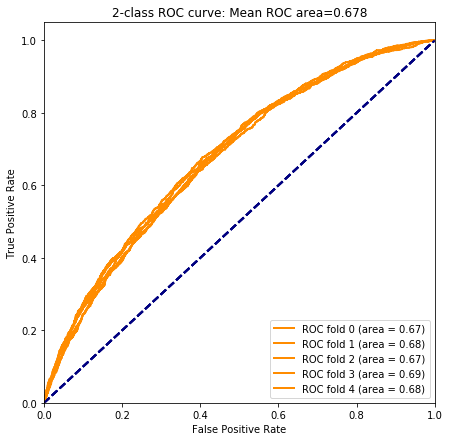

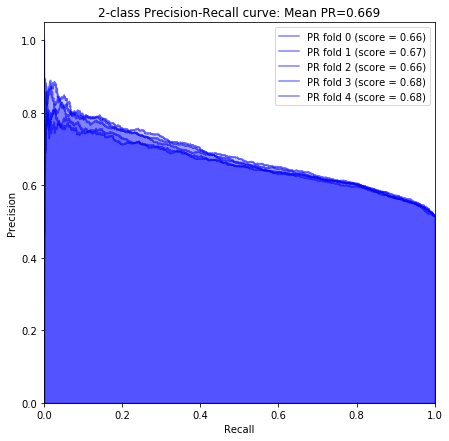

In [0]:
ROC(y_scores, y_tests)
PRC(y_scores, y_tests)

**GradientBoostingClassifier**

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
gb = GradientBoostingClassifier()
y_scores, y_tests = KFold(gb, x_data_le, y_data)

0.7317073170731707
0.7353328938694792
0.7164476966572426
0.7291339882770577
0.722935475855214
mean f1 score: 0.7271114743464329


**RandomForestClassifier**

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
# кросс-валидация ведется с помощью StratifiedKFold, количество фолдов - 5. + f1 score
def KFoldRF(estimator, x_data, y_data):
    skf = StratifiedKFold(n_splits=5)
    y_scores = pd.DataFrame()
    y_tests = pd.DataFrame()
    y_pred = pd.DataFrame() 
    f1 = np.array([])
    n = 0
    for train_index, test_index in skf.split(x_data, y_data):
        estimator.fit(x_data.iloc[train_index, :], y_data.iloc[train_index, 0])
        #y_scores['fold_'+str(n)] = pd.Series(estimator.decision_function(x_data.iloc[test_index, :]))
        y_pred['fold_'+str(n)] = pd.Series(estimator.predict(x_data.iloc[test_index, :]))
        #y_tests['fold_'+str(n)] = pd.Series(y_data.iloc[test_index, 0].values)
        f1 = np.append(f1, f1_score(y_data.iloc[test_index, 0], y_pred.iloc[:,n].dropna())) 
        print(f1_score(y_data.iloc[test_index, 0], y_pred.iloc[:,n].dropna()))
        n+=1
    print ('mean f1 score: '+str(np.mean(f1)))
    return (y_scores, y_tests)

In [0]:
clf=RandomForestClassifier(n_estimators=100)
y_scores, y_tests = KFoldRF(clf, x_data_le, y_data)

0.9995715142685748
0.9993145990404386
0.9994858611825194
0.9993145990404386
0.9991432488005484
mean f1 score: 0.999365964466504


In [0]:
###


### Лучше всего RandomForestClassifier